# Clasificador SVM

## Importamos las librerias a utilizar

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
#from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer


from sklearn import preprocessing
from sklearn.metrics import DistanceMetric
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt



## Cargamos el df

In [2]:
hotel = pd.read_csv('Datasets/hotels_train.csv') 
hotel_t = pd.read_csv('Datasets/hotels_test.csv')
hotel_orig = hotel_t.copy()

## Analisis exploratorio

In [3]:
hotel = hotel[hotel['adr']>0]
total_filas = hotel.shape[0]
hotel.shape

(61028, 32)

## Preprocesamiento

In [4]:
hotel['children'].fillna(0,inplace = True)
hotel['country'].fillna('PRT',inplace = True)
hotel['agent'].fillna(0,inplace = True)
hotel['company'].fillna(0,inplace = True)
columnas_eliminar=['meal','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','id','reservation_status_date']
hotel.drop(columnas_eliminar, axis='columns', inplace=True)

hotel_t['children'].fillna(0,inplace = True)
hotel_t['country'].fillna('PRT',inplace = True)
hotel_t['agent'].fillna(0,inplace = True)
hotel_t['company'].fillna(0,inplace = True)
columnas_eliminar=['meal','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','id','reservation_status_date']
hotel_t.drop(columnas_eliminar, axis='columns', inplace=True)

In [5]:
def higher_probability(a,b):
    if a == b:
        return 0
    else:
        return 1

hotel['hotel'] = hotel['hotel'].map({'City Hotel':1,'Resort Hotel':0},na_action=None)
hotel['arrival_date_month'] = hotel['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)
hotel['country'] = hotel['country'].apply(higher_probability,b='PTR')
hotel['market_segment'] = hotel['market_segment'].map({'Online TA':1,'Groups':2,'Offline TA/TO':3,'Direct':4,'Complementary':5,'Corporate':6,'Aviation':7,'Undefined':8},na_action=None)
hotel['distribution_channel'] = hotel['distribution_channel'].map({'TA/TO':1,'Direct':2,'Corporate':3,'GDS':4,'Undefined':5},na_action=None)
hotel['reserved_room_type'] = hotel['reserved_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10},na_action=None)
hotel['assigned_room_type'] = hotel['assigned_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10,'K':11,'I':12},na_action=None)
hotel['agent'] = hotel['agent'].apply(higher_probability,b=0)
hotel['company'] = hotel['company'].apply(higher_probability,b=0)


hotel_t['hotel'] = hotel_t['hotel'].map({'City Hotel':1,'Resort Hotel':0},na_action=None)
hotel_t['arrival_date_month'] = hotel_t['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)
hotel_t['country'] = hotel_t['country'].apply(higher_probability,b='PTR')
hotel_t['market_segment'] = hotel_t['market_segment'].map({'Online TA':1,'Groups':2,'Offline TA/TO':3,'Direct':4,'Complementary':5,'Corporate':6,'Aviation':7,'Undefined':8},na_action=None)
hotel_t['distribution_channel'] = hotel_t['distribution_channel'].map({'TA/TO':1,'Direct':2,'Corporate':3,'GDS':4,'Undefined':5},na_action=None)
hotel_t['reserved_room_type'] = hotel_t['reserved_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10},na_action=None)
hotel_t['assigned_room_type'] = hotel_t['assigned_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10,'K':11,'I':12},na_action=None)
hotel_t['agent'] = hotel_t['agent'].apply(higher_probability,b=0)
hotel_t['company'] = hotel_t['company'].apply(higher_probability,b=0)

In [6]:
#Dummies para deposit_type
hotel = pd.get_dummies(hotel, columns=['deposit_type'], drop_first=True)
hotel_t = pd.get_dummies(hotel_t, columns=['deposit_type'], drop_first=True)

#Dummies para customer_type
hotel = pd.get_dummies(hotel, columns=['customer_type'], drop_first=True)
hotel_t = pd.get_dummies(hotel_t, columns=['customer_type'], drop_first=True)

## Entrenamiento y Prediccion

In [7]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [8]:
target='is_canceled'
hotel_x=hotel.drop([target], axis='columns', inplace=False)
hotel_y = hotel[target].copy()

In [9]:
x_train, x_test, y_train, y_test = train_test_split(hotel_x, 
                                                    hotel_y, 
                                                    test_size=0.20,    #20% al conjunto de test
                                                    random_state=10,  #para poder reproducir el experimento
                                                    ) #stratify=y.values

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train) 
x_test_minmax  = min_max_scaler.transform(x_test) 

stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

Text(0, 0.5, 'Varianza Explicada (%)')

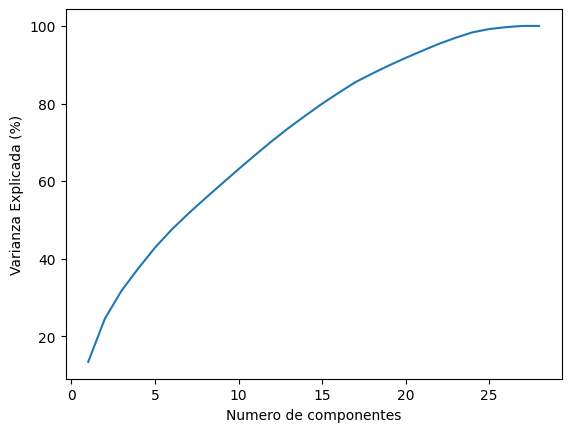

In [11]:
# PCA sobre los datos escalados
pca = PCA(n_components = None)
pca.fit(x_train_norm)

#Cantidad de Componentes
componentes = len(pca.explained_variance_ratio_) 

#Grafico la Varianza Explicada 
plt.plot(range(1,componentes+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada (%)")

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      6051
           1       0.84      0.74      0.78      6155

    accuracy                           0.80     12206
   macro avg       0.80      0.80      0.80     12206
weighted avg       0.80      0.80      0.80     12206



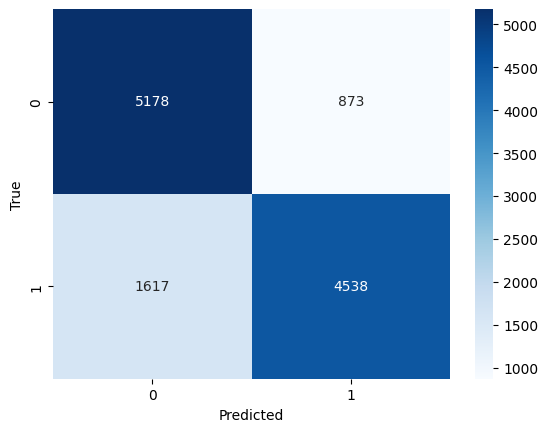

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Defino el tipo de escalado, la transformacion PCA y el modelo
_sc = StandardScaler()
_pca = PCA(n_components = 20)
_model = SVC()

#Creo un pipeline
svm_model = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('svm', _model)
])

#Entreno sobre los datos que serán previamente escalados y transformados
svm_model.fit(x_train,y_train)

#Hago la predicción y calculo las métricas
y_pred_pca=svm_model.predict(x_test)
metricas(y_pred_pca,y_test)

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      6051
           1       0.83      0.76      0.79      6155

    accuracy                           0.80     12206
   macro avg       0.80      0.80      0.80     12206
weighted avg       0.80      0.80      0.80     12206



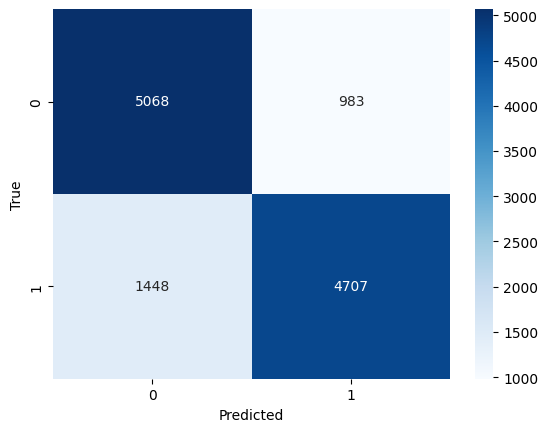

In [13]:
clf = SVC(kernel='poly', C=5, degree=3, gamma=1, coef0=2)
clf.fit(x_train_minmax, y_train)

y_pred_lin=clf.predict(x_test_minmax)
metricas(y_pred_lin,y_test)

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      6051
           1       0.84      0.77      0.80      6155

    accuracy                           0.81     12206
   macro avg       0.81      0.81      0.81     12206
weighted avg       0.81      0.81      0.81     12206



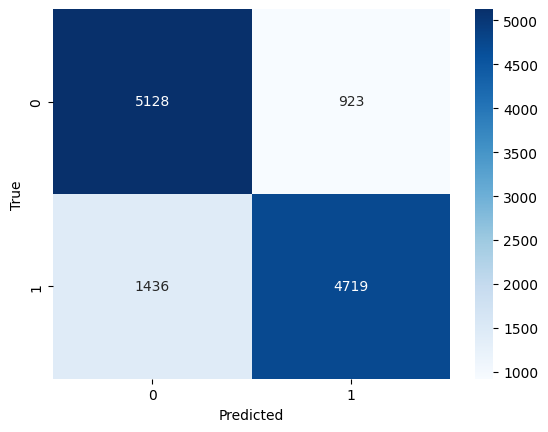

In [14]:
clf2 = SVC(kernel='rbf', C=5, gamma=2)
clf2.fit(x_train_minmax, y_train)

#Hago la predicción y calculo las métricas
y_pred_rad=clf2.predict(x_test_minmax)
metricas(y_pred_rad,y_test)

              precision    recall  f1-score   support

           0       0.75      0.82      0.78      6051
           1       0.81      0.73      0.77      6155

    accuracy                           0.78     12206
   macro avg       0.78      0.78      0.78     12206
weighted avg       0.78      0.78      0.78     12206



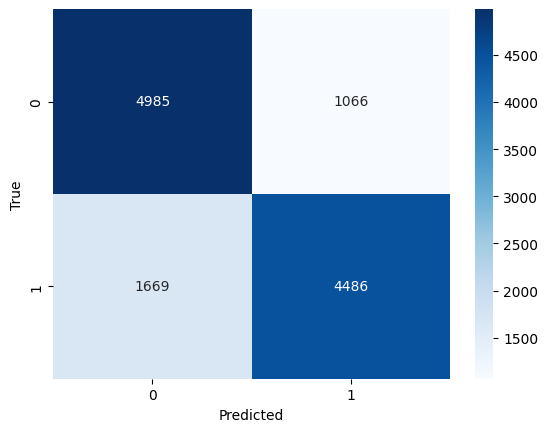

In [15]:
clf3 = SVC(kernel='linear', C=20)
clf3.fit(x_train_minmax, y_train)

y_pred_pol=clf3.predict(x_test_minmax)
metricas(y_pred_pol,y_test)

In [16]:
import pickle
pickle.dump(svm_model, open("svm_pipeline", "wb"))
pickle.dump(clf3, open("svm_linear", "wb"))
pickle.dump(clf2, open("svm_rbf", "wb"))
pickle.dump(clf, open("svm_poly", "wb"))